In [1]:
import shutil
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from lib import (
    load_exp_conf,
    load_exp_data,
    P3innDir,
    pi3nn_compute_PI_and_mean,
    FinnDir,
)

# Run

In [2]:
data_out_root = Path("../data_out").resolve()
assert data_out_root.exists()
pi3nn_root = data_out_root / "p3inn"
finn_root = data_out_root / "finn"
pi3nn_root.mkdir(exist_ok=True, parents=True)
finn_root.mkdir(exist_ok=True, parents=True)

In [3]:
data_core2_df = load_exp_data(name="Core 2")
display(data_core2_df.head())

,time,c_diss
0,0.000000,0.000000
1,0.838329,0.000096
2,1.377912,0.000062
3,1.879996,0.000061
4,2.379996,0.000052


### PI3NN on experimental data to obtain PIs for different quantiles

Training UP Network
Epoch      1, Train Loss: 8.12e+00, Validation Loss: 1.44e+01
Epoch 100000, Train Loss: 1.08e-03, Validation Loss: 7.67e-04
Epoch 200000, Train Loss: 9.75e-04, Validation Loss: 9.41e-04
Epoch 300000, Train Loss: 8.01e-04, Validation Loss: 1.85e-03
Epoch 400000, Train Loss: 7.97e-04, Validation Loss: 2.02e-03
Epoch 500000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Epoch 600000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Epoch 700000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Epoch 800000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Epoch 900000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Epoch 1000000, Train Loss: 7.97e-04, Validation Loss: 2.03e-03
Training DOWN Network
Epoch      1, Train Loss: 9.77e+00, Validation Loss: 8.15e+00
Epoch 100000, Train Loss: 1.09e-03, Validation Loss: 2.63e-03
Epoch 200000, Train Loss: 1.06e-03, Validation Loss: 2.78e-03
Epoch 300000, Train Loss: 1.04e-03, Validation Loss: 2.91e-03
Epoch 400000, Train Loss: 1

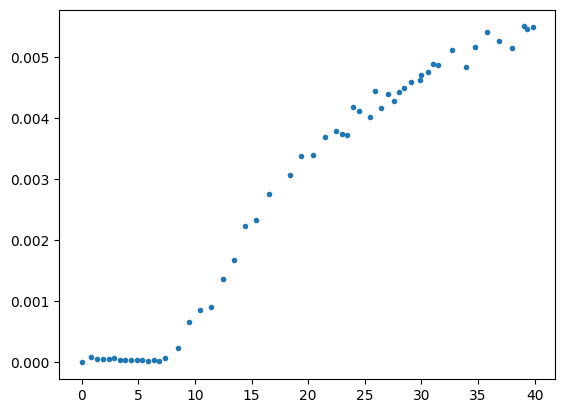

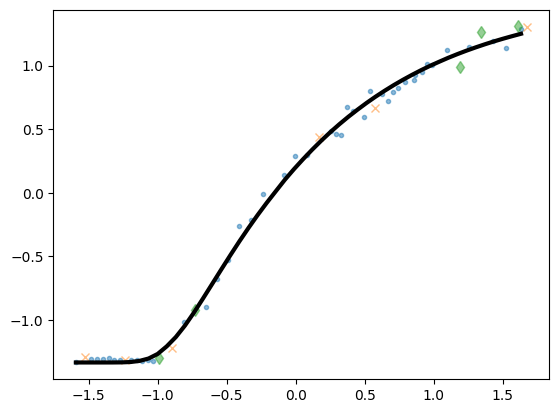

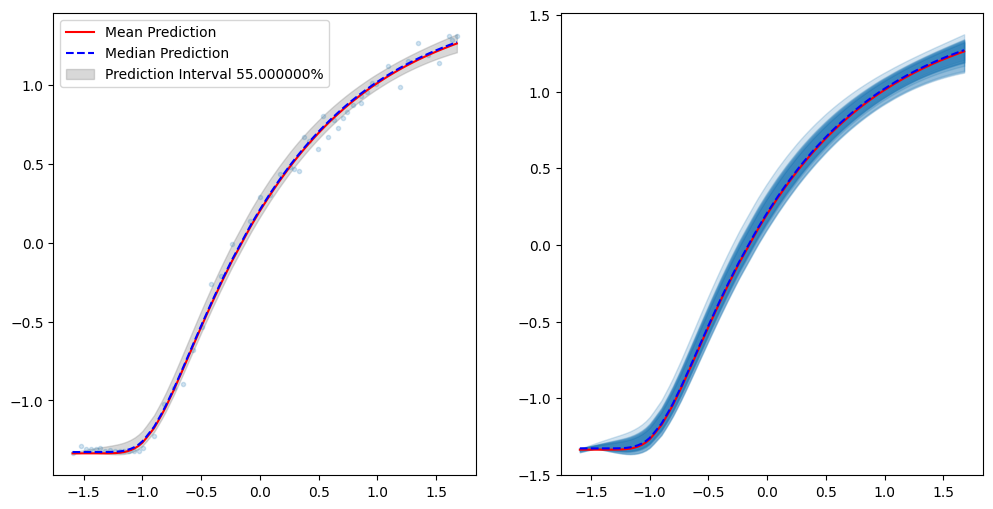

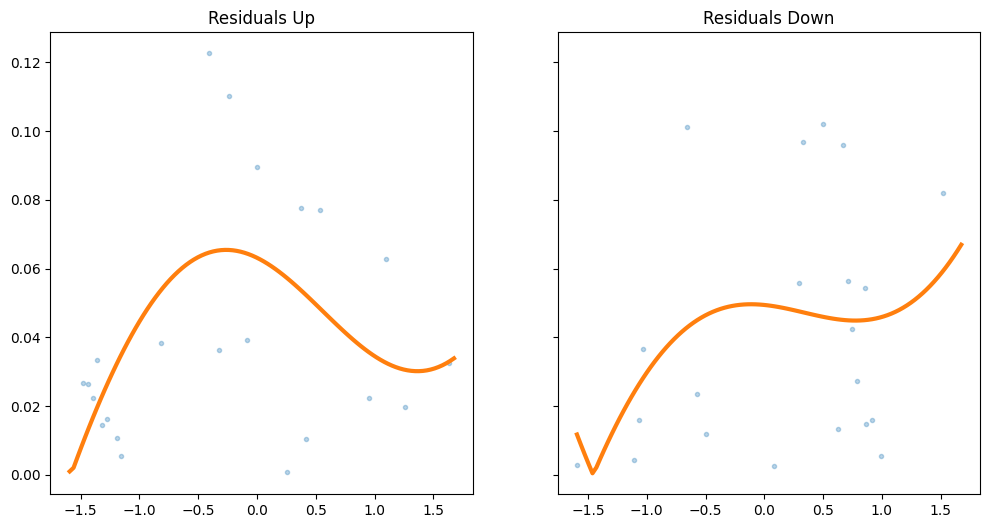

In [4]:
p3inn_core2_dir = P3innDir(pi3nn_root / "core2")
# shutil.rmtree(p3inn_core2_dir.path.absolute())
# p3inn_core2_dir = P3innDir(pi3nn_root / "core2")
np.save(p3inn_core2_dir.x_data_path, data_core2_df["time"].to_numpy().reshape(-1, 1))
np.save(p3inn_core2_dir.y_data_path, data_core2_df["c_diss"].to_numpy().reshape(-1, 1))

quantiles = [1.0 - 0.05 * i for i in range(1, 10)]

core2_dir = FinnDir(Path("../data_out/finn/core2"))
fp = np.load(core2_dir.get_data_pred_path(core2_dir.best_epoch))
xp = np.load(core2_dir.t_train_path)

def net_mean(x):
    y = np.interp(x, xp, fp).reshape(-1, 1)
    return y

pi3nn_compute_PI_and_mean(
    out_dir=p3inn_core2_dir.path,
    quantiles=quantiles,
    visualize=True,
    net_mean_=net_mean,
    max_iter=1000000,
)

### FINN on all quantiles to obtain retardations

In [6]:
finn_exp_root = finn_root / "p3inn_core2_new_multiprocessing"
finn_exp_root

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing')

In [7]:
conf_core2 = load_exp_conf(name="Core 2")
display(conf_core2)

{'D': 2.0045664000000002e-05,
 'por': 0.288,
 'rho_s': 1957.0,
 'X': 0.026034999999999996,
 'T': 39.824440010000004,
 'Nx': 20.0,
 'Nt': 55.0,
 'sample_radius': 0.02375,
 'Q': 0.00010435199999999999,
 'solubility': 1.6,
 'Dirichlet': 0.0,
 'Cauchy': 1.0}

In [8]:
import subprocess
from pathlib import Path

# Prepare a list of commands to run in parallel
commands = []

for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
    for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
        bound_file = Path(
            f"/tmp/bound_{bound_type}_{quantile:g}.npy"
        )  # Save bound data to file
        np.save(bound_file, bound)

        finn_dir = FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
        print(finn_dir.path.resolve())

        command = f"python3 run_finn_core2.py {finn_dir.path.resolve()} {bound_file}"
        commands.append(command)

/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.55
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.55
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.6
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.6
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.65
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.65
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.7
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.7
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.75
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.75
/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multip

In [9]:
# Write all commands to a temporary file (input for GNU Parallel)
commands_file = Path("/tmp/parallel_commands.txt")
with open(commands_file, "w") as f:
    f.write("\n".join(commands))
print(commands_file.resolve())

/private/tmp/parallel_commands.txt


In [10]:
command = f"cat {commands_file} | parallel -j 6 --bar"
# subprocess.run(command, check=True, shell=True)
print(command)

cat /tmp/parallel_commands.txt | parallel -j 6 --bar


In [13]:
!cat /tmp/parallel_commands.txt

python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.55 /tmp/bound_up_0.55.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.55 /tmp/bound_down_0.55.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.6 /tmp/bound_up_0.6.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.6 /tmp/bound_down_0.6.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.65 /tmp/bound_up_0.65.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.65 /tmp/bound_down_0.65.npy
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.7 /tmp/bound_up_0.7.npy
python3

In [11]:
!say "Done"

In [12]:
# for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
#     for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
#         finn_p3inn_core2_dir = FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
#         np.save(finn_p3inn_core2_dir.c_train_path, np.squeeze(bound))
#         t = np.linspace(
#             data_core2_df["time"].min(), data_core2_df["time"].max(), len(bound)
#         )
#         np.save(finn_p3inn_core2_dir.t_train_path, t)

#         print(f"{finn_p3inn_core2_dir.path.relative_to(finn_exp_root)}")
#         finn_fit_retardation(
#             out_dir=finn_p3inn_core2_dir.path,
#             is_exp_data=True,
#             n_epochs=21,
#             **conf_core2,
#         )